In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

In [8]:
os.listdir('.')

['master_dataset_09122019.pkl',
 'combo48.pkl',
 'rf+1.pickle',
 'combo.pkl',
 'Figs for thesis.ipynb',
 '1+24+48.keras',
 'ARMA.ipynb',
 'arma24.pkl',
 'last_period_24.pkl',
 '.DS_Store',
 '1+24+pred.keras',
 '1+pred.keras',
 'lstm48_pred.pkl',
 'rfdf48.pkl',
 '48.keras',
 'pred_error_24_abs.png',
 'prediction.pkl',
 'test_performance.ipynb',
 '1+24+48+pred.keras',
 'rf_final.pickle',
 'pred_error_48.png',
 'lstm_24pred.pkl',
 'rf+24.pickle',
 'lstm_24no.pkl',
 'master_dataset_31102019.pkl',
 'last_period_48.pkl',
 'price distribution.ipynb',
 'model_comparisons.ipynb',
 'master_dataset_06122019.pkl',
 'combo1.pkl',
 'combo24.pkl',
 'pred_error_1_abs.png',
 'arma1.pkl',
 'lstm_pred.pkl',
 'arma48.pkl',
 'target_prices.pkl',
 '.ipynb_checkpoints',
 'final_figs.ipynb',
 '1.keras',
 'pred_error_24.png',
 'rf+48.pickle',
 'RF_BM.ipynb',
 'lstm_48no.pkl',
 'pred_error_48_abs.png',
 'rfdf24.pkl',
 'Naive BM.ipynb',
 'pred_error_1.png',
 '24.keras',
 '1+24.keras',
 'rfdf1.pkl',
 'last_period

In [56]:
rf = pd.read_pickle('rf_final.pickle')
data = pd.read_pickle('../notebooks/data/master_dataset_09122019.pkl')

rf_1 = pd.read_pickle('rf+1.pickle')
rf_24 = pd.read_pickle('rf+24.pickle')
rf_48 = pd.read_pickle('rf+48.pickle')

In [57]:
d = data.dropna(how='any', axis=0)

In [58]:
data2 = pd.read_pickle('master_dataset_31102019.pkl')

In [59]:
rf_48.n_jobs = 1500
rf_24.n_jobs = 1500
rf_1.n_jobs = 1500

In [60]:
pred = rf_48.predict(d.drop(['NetCon_dk1', 'NetCon_dk2'], axis=1))
pred2 = rf_1.predict(d)
pred_3 = rf_24.predict(d)

In [61]:
d['pred+48'] = list(pred)

In [62]:
new_feature = d['dk2'].copy()

In [63]:
new_feature = pd.DataFrame(new_feature, index=d.index)
new_feature.columns = ['price']

In [64]:
def is_in_range(x, lower, upper, val):
    if lower < x <= upper:
        return val
    else:
        return 0

In [65]:
qs = [-100]
for i in range(1, 101):
  q = i
  qs.append(np.percentile(d['dk2'], q))

In [66]:
ss = dict()
for i, (lower, upper) in enumerate(zip(qs[:-1], qs[1:])):
  print(lower, upper)
  s = new_feature['price'].apply(lambda row: is_in_range(row, lower, upper, i))
  ss[i] = s

-100 26.4894
26.4894 58.6596
58.6596 73.75970000000001
73.75970000000001 86.6496
86.6496 99.92
99.92 114.2276
114.2276 125.92860000000002
125.92860000000002 135.4368
135.4368 143.6191
143.6191 149.36
149.36 154.5289
154.5289 159.15879999999999
159.15879999999999 163.33870000000002
163.33870000000002 167.24720000000002
167.24720000000002 171.42
171.42 175.2584
175.2584 178.74
178.74 181.7282
181.7282 184.72
184.72 187.0
187.0 189.94
189.94 193.1256
193.1256 195.66999999999996
195.66999999999996 198.65000000000003
198.65000000000003 201.3175
201.3175 204.22
204.22 207.1
207.1 209.29
209.29 211.69
211.69 214.01
214.01 215.9669
215.9669 217.83000000000004
217.83000000000004 219.75
219.75 221.61
221.61 223.30649999999997
223.30649999999997 224.77
224.77 226.6
226.6 228.5562
228.5562 230.2661
230.2661 231.87200000000007
231.87200000000007 233.84
233.84 235.65000000000003
235.65000000000003 237.62
237.62 239.13
239.13 241.0455
241.0455 242.99
242.99 245.0153
245.0153 246.63039999999995
246.63

In [67]:
_df = pd.DataFrame(ss)

In [68]:
d['price_bin'] = _df.sum(axis=1)

In [69]:
target = d['dk2'].shift(-48)
target = target.dropna(how='any', axis=0)

In [70]:
preds = rf.predict(d)
preds = pd.DataFrame(preds[0:-48], index=target.index)

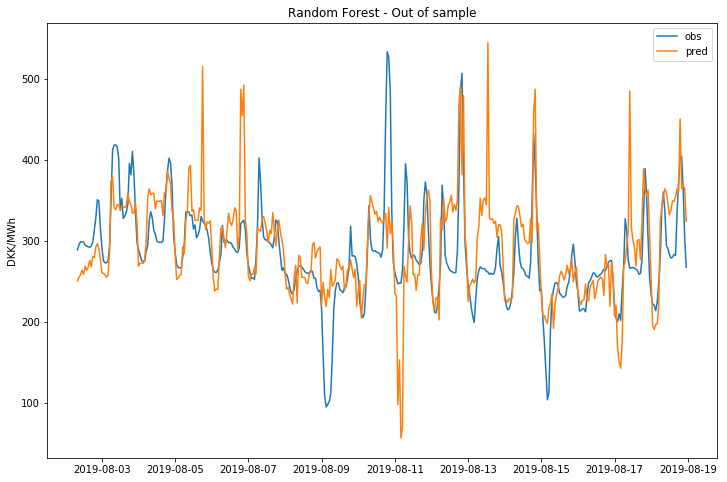

In [71]:
plt.figure(figsize=(12, 8))
plt.title('Random Forest - Out of sample')
plt.plot(target[-2800:-2400], label='obs')
plt.plot(preds[-2800:-2400], label='pred')
plt.ylabel('DKK/MWh')
plt.legend()
plt.show()

In [25]:
import datetime
preds_test = preds[preds.index.date >= datetime.date(2019, 9, 1)]
target_test = target[target.index.date >= datetime.date(2019, 9, 1)]

In [26]:
MAE = [np.abs(preds_test[0][i] - target_test[i]) for i in range(len(target_test))]


In [27]:
np.array(MAE).mean()

55.49081944444445

## LSTM

In [28]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop

In [29]:
target = pd.read_pickle('target_prices.pkl')
y_scaler_1 = MinMaxScaler()
y_scaler_1.fit(target)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [30]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, 37,),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(3, activation='relu'))

In [31]:
warmup_steps = 30

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    #loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    #loss = tf.losses.softmax_cross_entropy(y_true_slice, y_pred_slice)
    loss = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [32]:
d['pred+1'] = list(pred2)
d['pred+24'] = list(pred_3)

In [33]:
x_sc = MinMaxScaler()
data_scaled = x_sc.fit_transform(d)

In [34]:
model.load_weights('1+24+48+pred.keras')

In [37]:
preds = model.predict(np.expand_dims(data_scaled, axis=0))


In [38]:
store_preds = preds

In [39]:
preds_resc = y_scaler_1.inverse_transform(store_preds[0, :, :])

In [40]:
preds_resc_48 = preds_resc[:, -1]

In [41]:
obs_48 = d['dk2'].shift(-48)

In [42]:
preds_resc_48_df = pd.DataFrame(preds_resc_48, index=obs_48.index)

In [43]:
t = [np.abs(preds_resc_48[i] - obs_48[i]) for i in range(len(obs_48))]

In [44]:
MAE = pd.DataFrame(t, index=d.index)

In [45]:
MAE = MAE.dropna(how='any', axis=0)

In [48]:
test = MAE[MAE.index.date >= datetime.date(2017, 1, 1)]

In [53]:
test.std()

0    70.526639
dtype: float64

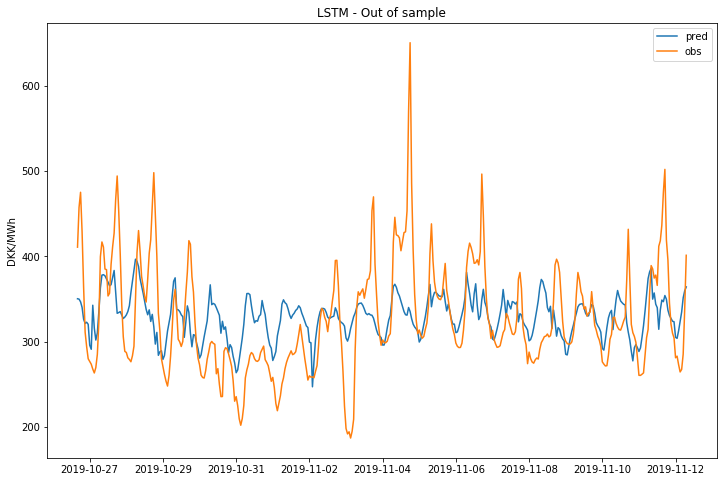

In [131]:
plt.figure(figsize=(12, 8))
plt.title('LSTM - Out of sample')
plt.plot(preds_resc_48_df[-800:-400], label='pred')
plt.plot(obs_48[-800:-400], label='obs')
plt.ylabel('DKK/MWh')
plt.legend()

In [74]:
predsrf_train = preds[preds.index.date < datetime.date(2017, 1, 1)]
predsrf_test = preds[preds.index.date >= datetime.date(2017, 1, 1)]

In [79]:
predslstm_train = preds_resc_48_df[preds_resc_48_df.index.date < datetime.date(2017, 1, 1)]
predslstm_test = preds_resc_48_df[preds_resc_48_df.index.date >= datetime.date(2017, 1, 1)]

In [80]:
avg_train = predsrf_train*0.5 + predslstm_train*0.5
avg_test = predsrf_test*0.5 + predslstm_test*0.5

In [84]:
target_train = target[target.index.date < datetime.date(2017, 1, 1)]
target_test = target[target.index.date >= datetime.date(2017, 1, 1)]

In [91]:
print("is std:", np.abs(avg_train[0] - target_train).std())
print("oos std:", np.abs(avg_test[0] - target_test).std())

is std: 45.821196609384366
oos std: 55.05495741636773


In [132]:
avg = preds_test*0.5 + preds_resc_48_df[(preds_resc_48_df.index.date >= datetime.date(2019, 9, 1)) & (preds_resc_48_df.index.date < datetime.date(2019, 11, 27))]*0.5

In [137]:
def avg_estimator(lambd):
    avg = preds_test*lambd + preds_resc_48_df[(preds_resc_48_df.index.date >= datetime.date(2019, 9, 1)) & (preds_resc_48_df.index.date < datetime.date(2019, 11, 27))]*(1-lambd)
    return np.abs(avg[0] - target_test).mean()

In [133]:
np.abs(avg[0] - target_test).mean()


49.03529614897969

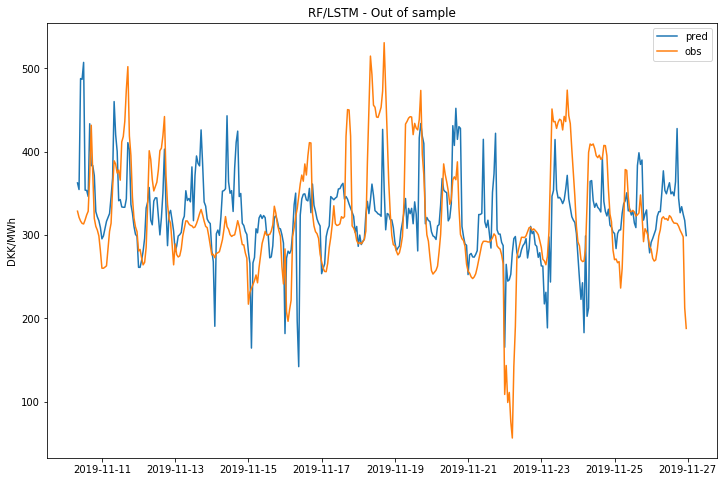

In [136]:
plt.figure(figsize=(12, 8))
plt.title('RF/LSTM - Out of sample')
plt.plot(avg[-400:], label='pred')
plt.plot(target_test[-400:], label='obs')
plt.ylabel('DKK/MWh')
plt.legend()
plt.show()

In [146]:
x = np.linspace(0, 1, 21)
y = [avg_estimator(i) for i in x]

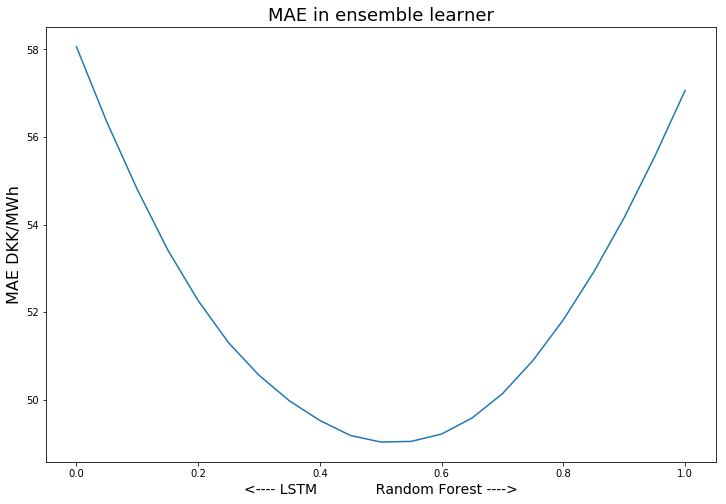

In [157]:
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('MAE in ensemble learner', fontsize=18)
plt.xlabel('<---- LSTM             Random Forest ---->', fontsize=14)
plt.ylabel('MAE DKK/MWh', fontsize= 16)
plt.show()

In [149]:
y

[58.05820325215664,
 56.33960489040091,
 54.80122584305683,
 53.42286960515868,
 52.263591695225784,
 51.30084347575105,
 50.558736255204366,
 49.975312476158905,
 49.527869415084425,
 49.185989111731566,
 49.03529614897969,
 49.04967902385384,
 49.21843852063456,
 49.58357152080612,
 50.140003668318116,
 50.89518084753337,
 51.826067042805946,
 52.91946294001724,
 54.15805778075847,
 55.54893112007703,
 57.05921408045968]